# Modeling

### Setup

In [158]:
import pickle
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt




df = pickle.load(open("mypickle.pickle", "rb"))
df.drop('plc', axis=1, inplace = True)

def odds_creation(row):
    if int(row['winodds']) <= 20:
        return 'strong'
    if int(row['winodds']) > 20 and int(row['winodds']) <= 50:
        return 'fair'
    else:
        return 'low'
    

df['odds'] = df.apply(lambda row: odds_creation(row), axis=1)
df = pd.get_dummies(df, columns = ['odds'])

x_data = df
y_data = df['Target_Value']

#x_data.drop('Target_Value', axis=1, inplace=True)
x_data.drop('declarwt', axis=1, inplace = True)






### Train Test Split / Validation

In [115]:
X, X_test, y, y_test = train_test_split(x_data, y_data, 
                                                    test_size = 0.21, shuffle=False)


In [116]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size = 0.10, shuffle=False)



### Oversampling attempt

In [117]:


import imblearn.over_sampling
import numpy as np

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

ratio = {1 : n_pos * 3, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_train, y_train)



lm = LogisticRegression()
lm.fit(X_tr_rs, y_tr_rs)

print('OverSampled Logistic Regression Test Recall: %.3f, F1: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, lm.predict(X_val)), f1_score(y_val, lm.predict(X_val)), roc_auc_score(y_val, lm.predict_proba(X_val)[:,1])))





OverSampled Logistic Regression Test Recall: 0.803, F1: 0.473, Test AUC: 0.741


/Users/brandon.mcneil/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Logistic Regressions

In [118]:
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear')
lr_oversamp_balanced = LogisticRegression(class_weight='balanced', solver='liblinear')
lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1}, solver='liblinear')

lr_balanced.fit(X_train, y_train)
lr_oversamp_balanced.fit(X_tr_rs, y_tr_rs)
lr_4x.fit(X_train, y_train)



print('Balanced class weights Logistic Regression Test Recall: %.3f, Precision: %.3f F1: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, lr_balanced.predict(X_val)), precision_score(y_val, lr_balanced.predict(X_val)), f1_score(y_val, lr_balanced.predict(X_val)), roc_auc_score(y_val, lr_balanced.predict_proba(X_val)[:,1])))

print('Balanced oversampling class weights Logistic Regression Test Recall: %.3f, Precision: %.3f F1: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, lr_oversamp_balanced.predict(X_val)), precision_score(y_val, lr_oversamp_balanced.predict(X_val)), f1_score(y_val, lr_oversamp_balanced.predict(X_val)), roc_auc_score(y_val, lr_oversamp_balanced.predict_proba(X_val)[:,1])))

lr_4x.fit(X_train, y_train)
print('4:1 class weights Logistic Regression Test Recall: %.3f, precision %.3f, F1: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, lr_4x.predict(X_val)), precision_score(y_val, lr_4x.predict(X_val)), f1_score(y_val, lr_4x.predict(X_val)), roc_auc_score(y_val, lr_4x.predict_proba(X_val)[:,1])))




Balanced class weights Logistic Regression Test Recall: 0.784, Precision: 0.341 F1: 0.476, Test AUC: 0.745
Balanced oversampling class weights Logistic Regression Test Recall: 0.796, Precision: 0.342 F1: 0.479, Test AUC: 0.745
4:1 class weights Logistic Regression Test Recall: 0.822, precision 0.331, F1: 0.472, Test AUC: 0.744


## Modeling on the Balanced Model

Text(0.5, 1.0, 'Precision-Recall Curve')

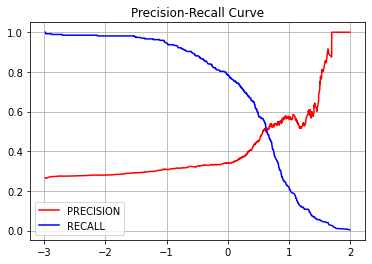

In [119]:
from sklearn.metrics import precision_recall_curve
decision_function = lr_balanced.decision_function(X_val)

precision, recall, treshold = precision_recall_curve(y_val, decision_function)
  
# Plot the output.
plt.plot(treshold, precision[:-1], c ='r', label ='PRECISION')
plt.plot(treshold, recall[:-1], c ='b', label ='RECALL')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve')


### Setting Threshold

In [120]:
df = lr_balanced.decision_function(X_val)
predict_actual =  lr_balanced.predict(X_val)

precision_score(y_val, predict_actual)

# Set the value of decision threshold.
decision_teshold = 0.75
  
# Desired prediction to increase precision value.
desired_predict =[]
  
# Iterate through each value of decision function output
# and if  decision score is > than Decision threshold then,
# append (1) to the empty list ( desired_prediction) else
# append (0).
for i in df:
    if i<decision_teshold:
        desired_predict.append(0)
    else:
        desired_predict.append(1)

# Old Precision Value
print("old precision value:", precision_score(y_val, predict_actual))
# New precision Value  
print("new precision value:", precision_score(y_val, desired_predict))


print(recall_score(y_val, predict_actual), recall_score(y_val, desired_predict))
print(f1_score(y_val, desired_predict))

old precision value: 0.3414239482200647
new precision value: 0.5270935960591133
0.7843866171003717 0.39776951672862454
0.45338983050847464


## Confusion Matrix

In [207]:
import seaborn as sns
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Show', 'Show'],
           yticklabels=['Not Show', 'Show']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    
#make_confusion_matrix(lm, threshold = .35)


from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(lr_balanced, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### Random Forest Model

In [122]:
from sklearn.model_selection import cross_val_score, cross_val_predict 


r_forest = RandomForestClassifier(n_estimators=200, max_depth=10,max_features='auto')

r_forest.fit(X_tr_rs, y_tr_rs)


print('Random Forest Test Recall: %.3f, precision %.3f, F1: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, r_forest.predict(X_val)), precision_score(y_val, r_forest.predict(X_val)), f1_score(y_val, r_forest.predict(X_val)), roc_auc_score(y_val, r_forest.predict_proba(X_val)[:,1])))



Random Forest Test Recall: 0.621, precision 0.439, F1: 0.515, Test AUC: 0.749


In [123]:
from sklearn.model_selection import cross_val_score, cross_val_predict 


r_forest_no_sample = RandomForestClassifier(n_estimators=125, max_depth=10,max_features='auto', class_weight={1 : 4, 0 : 1})

r_forest_no_sample.fit(X_train, y_train)


print('Random Forest Test Recall: %.3f, precision %.3f, F1: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, r_forest_no_sample.predict(X_val)), precision_score(y_val, r_forest_no_sample.predict(X_val)), f1_score(y_val, r_forest_no_sample.predict(X_val)), roc_auc_score(y_val, r_forest_no_sample.predict_proba(X_val)[:,1])))


Random Forest Test Recall: 0.684, precision 0.383, F1: 0.491, Test AUC: 0.750


In [124]:
import pandas as pd
important_features = pd.Series(data=r_forest.feature_importances_,index=X_train.columns)
important_features.sort_values(ascending=False,inplace=True)

In [208]:
interactive(lambda threshold: make_confusion_matrix(r_forest, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

## XGBoost Model

In [126]:
import xgboost as xgb
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_tr_rs, y_tr_rs),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_tr_rs, y_tr_rs, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

/Users/brandon.mcneil/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [127]:
print('XGBoost Test Recall: %.3f, precision %.3f, F1: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, gbm.predict(X_val)), precision_score(y_val, gbm.predict(X_val)), f1_score(y_val, gbm.predict(X_val)), roc_auc_score(y_val, gbm.predict_proba(X_val)[:,1])))


XGBoost Test Recall: 0.606, precision 0.438, F1: 0.509, Test AUC: 0.748


In [128]:
import xgboost as xgb
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train, y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

/Users/brandon.mcneil/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [129]:
print('XGBoost Test Recall: %.3f, precision %.3f, F1: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, gbm.predict(X_val)), precision_score(y_val, gbm.predict(X_val)), f1_score(y_val, gbm.predict(X_val)), roc_auc_score(y_val, gbm.predict_proba(X_val)[:,1])))


XGBoost Test Recall: 0.305, precision 0.678, F1: 0.421, Test AUC: 0.737


ROC AUC score =  0.7704712456114325


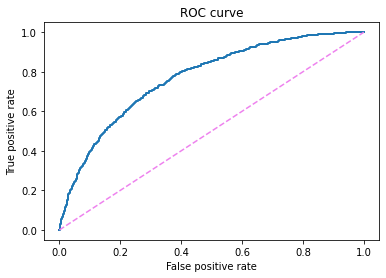

In [185]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, r_forest.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig('test2png.png', dpi=100)
print("ROC AUC score = ", roc_auc_score(y_test, r_forest.predict_proba(X_test)[:,1]))



## Final Model Results

In [166]:

r_forest = RandomForestClassifier(n_estimators=200, max_depth=10,max_features='auto', class_weight='balanced')

r_forest.fit(X, y)


print('Random Forest Test Recall: %.3f, precision %.3f, F1: %.3f, Test AUC: %.3f' % \
      (recall_score(y_test, r_forest.predict(X_test)), precision_score(y_test, r_forest.predict(X_test)), f1_score(y_test, r_forest.predict(X_test)), roc_auc_score(y_test, r_forest.predict_proba(X_test)[:,1])))


Random Forest Test Recall: 0.576, precision 0.462, F1: 0.513, Test AUC: 0.770


## Model Predictions

In [215]:
print(y_test[16:28])


r_forest.predict_proba(X_test[16:28])

890      1
2007     1
3124     1
4240     0
5358     0
6470     0
7576     0
8677     0
9772     0
10849    0
11902    0
12878    0
Name: Target_Value, dtype: int64


array([[0.16352319, 0.83647681],
       [0.90834618, 0.09165382],
       [0.48923981, 0.51076019],
       [0.91060015, 0.08939985],
       [0.97272334, 0.02727666],
       [0.57539564, 0.42460436],
       [0.36140953, 0.63859047],
       [0.55215632, 0.44784368],
       [0.7782153 , 0.2217847 ],
       [0.74931355, 0.25068645],
       [0.75278734, 0.24721266],
       [0.79262081, 0.20737919]])

## Feature Importance of Final Random Forest Model

Text(0.5, 0, 'Random Forest Feature Importance')

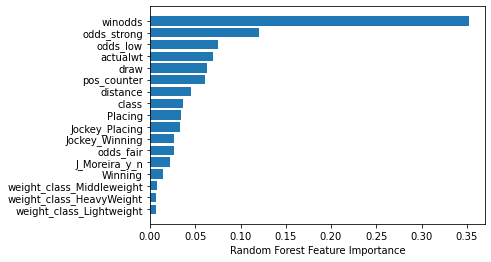

In [214]:

sorted_idx = r_forest.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], r_forest.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [135]:
print(y_test[-42:-28])

lr_balanced.predict_proba(X_test[-42:-28])

1111     1
2228     1
3345     1
4461     0
5579     0
6691     0
7797     0
8898     0
9991     0
11069    0
12115    0
13076    0
13524    0
13907    0
Name: Target_Value, dtype: int64


array([[0.41709385, 0.58290615],
       [0.33037012, 0.66962988],
       [0.16689323, 0.83310677],
       [0.39521105, 0.60478895],
       [0.32436657, 0.67563343],
       [0.51601962, 0.48398038],
       [0.84245219, 0.15754781],
       [0.51878812, 0.48121188],
       [0.66578194, 0.33421806],
       [0.50039453, 0.49960547],
       [0.95122595, 0.04877405],
       [0.34408781, 0.65591219],
       [0.92286741, 0.07713259],
       [0.95477046, 0.04522954]])